# Projeto Final - Sistemas de Controle II

**Integrantes (nome e RA)**
- Murilo de Assis Cabral, 11201921352
- Gabriel Raniere Gomes Silva, 11201920212



**instruções para rodar o projeto**

Professora, compartilhamos esse projeto no google colab com o seu email da UFABC. Para rodar o projeto basta abrí-lo, clicar em `runtime` e depois `run all`. Serão executadas todas as células com código em ordem. e os gráficos devem aparecer assim como estão nesse PDF.

Caso não encontre o projeto compartilhado no drive, segue abaixo o link.

 https://colab.research.google.com/drive/1Pcrt22cj4aNUn3G0zccfJBRC8jSXwKXU?usp=sharing

## Resumo

O projeto em questão é baseado na modelagem do sistema de um pêndulo invertido.
Esse sistema é observado pela ótica estudada na disciplina de Sistemas de Controle II. A partir disso, foram projetados compensadores, a fim de melhorar o sistema e fazer com que ele se adeque a diferentes requerimentos. Por fim, foi feita uma breve discussão dos resultado e das vantagens e desvantagens de cada tipo de compensador.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import control
import sympy

import numpy as np

##  Modelagem do Sistema

**Definir a função de transferência do sistema relacionando posição linear do carrinho com a tensão do motor de forma a obter $\frac{V_m}{x_{m}}$.**


In [3]:
# Parametros do Sistema
Rm = 2.6
Jm = 3.9e-7
Kt = 7.68e-3
nm = 1
Km = 7.68e-3
Kg = 3.71
ng = 1
Mc = 0.94
rmp = 63e-4
Beq = 5.4
g = 9.81

Manipulando as equações providas no manual do kit educacional obtemos a seguinte expressão:

\begin{align}
X_{c} \left[ s^2 \left( M_c + \frac{\eta_{g} K_{g}^2 J_{m}}{r_{mp}^2}\right) + s \left(\frac{\eta_{g} K_{g}^2 K_{t} K_{m}}{R_{m} r_{mp}^2} + B_{eq} \right) \right] = V_{m} \frac{\eta_g K_{g} K_{t} \eta_m }{R_{m} r_{mp}}
\end{align}

Logo podemos encontrar a função de transferência

\begin{align}
\frac{X_c(s)}{V_m(s)} = \frac{\frac{\eta_g K_{g} K_{t} \eta_m }{R_{m} r_{mp}}}{ \left[ s^2 \left( M_c + \frac{\eta_{g} K_{g}^2 J_{m}}{r_{mp}^2}\right) + s \left(\frac{\eta_{g} K_{g}^2 K_{t} K_{m}}{R_{m} r_{mp}^2} + B_{eq} \right) \right]}
\end{align}

In [4]:
num = (ng*Kg*Kt*nm)/(Rm*rmp)
s2 = (ng*(Kg**2)*Jm)/(rmp**2)
s = ng*(Kg**2)*Kt*Km/(Rm*rmp**2) + Beq

sys = control.tf([num], [s2+Mc, s, 0])
print(sys)


       1.739
-------------------
1.075 s^2 + 13.27 s



Vemos, então, que a função de transferência do sistema é dada por:

\begin{align}
P(s) = \frac{1.739}{1.075s^2 + 13.27 s} = \frac{1.739}{s(1.075s + 13.27)} =  \frac{0.131}{s(0.081s + 1)}
\end{align}

Margem de ganho:  inf
Margem de fase:  89.39122284060005
inf, 89.39122284060005, nan, 0.1311052362384412


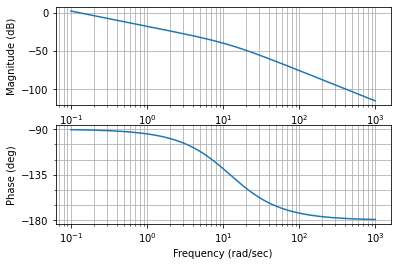

In [5]:
# Diagrama de bode
mag, phase, omega = control.bode(sys, dB=True, omega_limits=[10e-2, 10e2])
gm, pm, wcg, wcp = control.margin(sys)
print('Margem de ganho: ', gm)
print('Margem de fase: ', pm)
print(f'{gm}, {pm}, {wcg}, {wcp}')

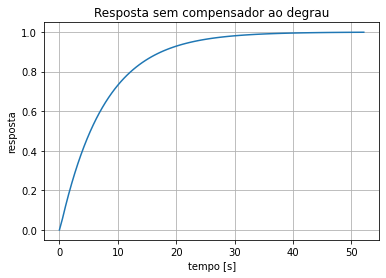

In [6]:
# Resposta ao degrau unitário
closed_sys = control.feedback(sys, 1)
time, response = control.step_response(closed_sys)
plt.plot(time, response)
plt.xlabel("tempo [s]")
plt.ylabel("resposta")
plt.title("Resposta sem compensador ao degrau")
plt.grid()

Text(0.5, 1.0, 'Resposta sem compensador à rampa')

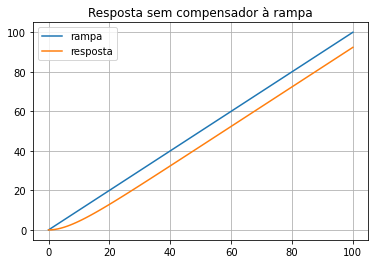

In [7]:
# Resposta à rampa unitária
t = np.linspace(0, 100, 100)
ramp = np.linspace(0, 100, 100)
time, response = control.forced_response(closed_sys, U=ramp, T=t)
plt.plot(t, ramp)
plt.plot(t, response)
plt.grid(True)
plt.legend(['rampa', 'resposta'])
plt.title('Resposta sem compensador à rampa')

## Projeto do Compensador de Avanço de Fase
**Projetar compensador de avanço de modo que o sistema tenha $e_{ss} < 1\%$ e $M_p < 5\% $**

Como o sistema é do tipo 1, o erro de estado estacionário que queremos controlar é o de resposta para a rampa. Temos então que:

\begin{align}
e_{ss} = \frac{1}{K} \lt 1\% \implies K = \frac{1}{e_{ss}} \gt 100 \implies K_c \gt \frac{100}{0.131}
\end{align}

onde K é o ganho total absoluto do sistema e $K_c$ é o ganho absoluto do controlador. Assim, temos que o ganho do controlador deve ser $K_c \approx 764$ ou $K_c = 58dB$. Presisamos então fazer o diagrama de Bode do sistema com o ganho ajustado.



Margem de ganho:  inf
Margem de fase:  19.896954596349786


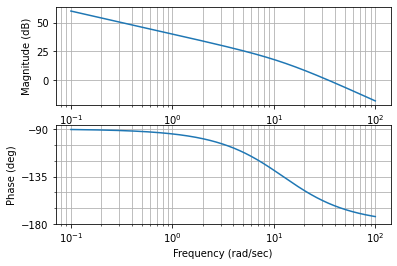

In [8]:
kc_lead = 764
gain_comp_lead = control.tf([kc_lead], [1])
gain_comp_lead_sys = control.series(gain_comp_lead, sys)
control.bode(gain_comp_lead_sys, dB=True, omega_limits=[10e-2, 10e1])
gm, pm, wcg, wcp = control.margin(gain_comp_lead_sys)
print('Margem de ganho: ', gm)
print('Margem de fase: ', pm)

Queremos uma magnitude de sobressinal menor que 5% do valdor de estado estacionário do sistema, logo precisamos encontrar o fato de amortecimento que permite esse comportamento.

\begin{align}
M_p = e^{-\frac{\zeta}{\sqrt{1-\zeta^2}} \pi} \implies \frac{\zeta^2}{1-\zeta^2} = -\frac{ln(M_p)}{\pi} \implies \zeta = \sqrt{\frac{ln(M_p)}{\pi^2 + ln(M_p)} }
\end{align}

In [9]:
Mp = 0.05
dampening_coef = -np.log(Mp)/np.sqrt(np.log(Mp) + np.pi**2)
print('Coef. de amortecimento: ', dampening_coef)

Coef. de amortecimento:  1.1426211898253689


A partir do coeficiente de amortecimento, podemos encontrar a margem de fase que servirá como critério para o projeto de controlador por avanço com base no diagrama de Bode. Para isso usamos a expressão

\begin{align}
MF = tan^{-1} \left( \frac{2 \zeta}{\sqrt{ \sqrt{1 + 4 \zeta^4} - 2\zeta^2}}\right)
\end{align}

In [10]:
phase_margin = np.arctan((2*dampening_coef)/(np.sqrt(np.sqrt(1 + 4*dampening_coef**4) - 2*dampening_coef**2)))
print('Margem de fase desejada: ', np.degrees(phase_margin))

Margem de fase desejada:  79.342584849016


Como temos uma margem de fase de 19,89˚ no sistema com compensação de ganho e desejamos uma margem de fase de 79,34˚ podemos determinar $\phi_m$ como:

\begin{align}
\phi_m = MF_{desejada} - MF_{sistema} = 59,45˚
\end{align}

In [11]:
phi_m = np.radians(59.45)
alpha = (np.sin(phi_m) + 1)/(1 - np.sin(phi_m))
print('alpha: ', alpha)

alpha:  13.407760535530644


Uma vez que temos o valor de $\alpha$ podemos encontrar o lugar onde a magnitude deve cruzar o 0dB no sistema compensado usando a expressão

\begin{align}
10log(\alpha) = M_c
\end{align}

In [12]:
Mc_novo = 10*np.log10(alpha)
print('Novo zero: ', Mc_novo)

Novo zero:  11.27356244795572


No ponto onde a magnitude é 11,27 a frequência é de $\omega_c = 15 rad/s$. Finalmente, podemos determinar o polo e o zero do compensador por avanço.


764 s + 3130
------------
 s + 54.92



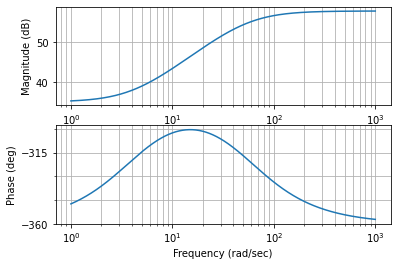

In [13]:
wc = 15
pole = wc*np.sqrt(alpha)
zero = pole/alpha

lead_compensator = control.tf(kc_lead*np.array([1, zero]), np.array([1, pole]))
control.bode(lead_compensator, dB=True)
print(lead_compensator)

Colocando o controlador em série com a planta obtemos o seguinte diagrama de Bode.


         1329 s + 5444
-------------------------------
1.075 s^3 + 72.33 s^2 + 728.7 s



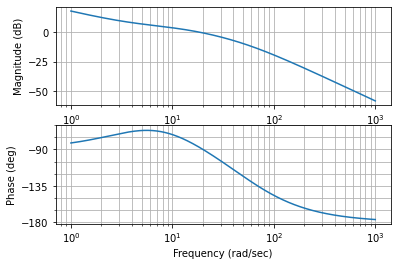

In [14]:
sys_lead_compensated = control.series(lead_compensator, sys)
control.bode(sys_lead_compensated, dB=True)
print(sys_lead_compensated)

Resta agora analisar a resposta do sistema ao degrau unitário e à rampa.

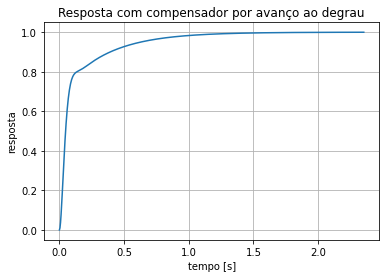

In [15]:
# Resposta ao degrau unitário
closed_lead_compensated_sys = control.feedback(sys_lead_compensated, 1)
time, response = control.step_response(closed_lead_compensated_sys)
plt.plot(time, response)
plt.xlabel("tempo [s]")
plt.ylabel("resposta")
plt.title("Resposta com compensador por avanço ao degrau")
plt.grid()

Text(0.5, 1.0, 'Resposta com compensador por avanço à rampa')

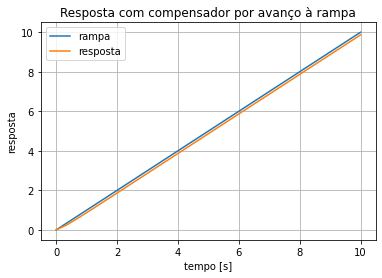

In [16]:
# Resposta à rampa unitária
t = np.linspace(0, 10, 30)
ramp = np.linspace(0, 10, 30)
time, response = control.forced_response(closed_lead_compensated_sys, U=ramp, T=t)
plt.plot(t, ramp)
plt.plot(t, response)
plt.legend(['rampa', 'resposta'])
plt.xlabel("tempo [s]")
plt.ylabel("resposta")
plt.grid(True)
plt.title('Resposta com compensador por avanço à rampa')

## Projeto do Compensador de Atraso de Fase
**Projetar controlador de atraso de modo que o sistema tenha $e_{ss} < 0.1\%$ e $M_p < 5\% $**

Assim como no item anterior vamos começar encontrando o valor de K necessário para que o erro de estado estacionário fique dentro do limite de projeto estabelecido. Temos então

\begin{align}
e_{ss} = \frac{1}{K} \lt 0.1\% \implies K = \frac{1}{e_{ss}} \gt 1000 \implies K_c \gt \frac{1000}{0.131}
\end{align}

Assim, concluímos que o ganho do controlador deve ser de 7634 ou 78dB. Plotamos então o diagrama de Bode do sistema com ganho compensado para determinar sua margem de fase.

Margem de ganho:  inf
Margem de fase:  6.354928371254374


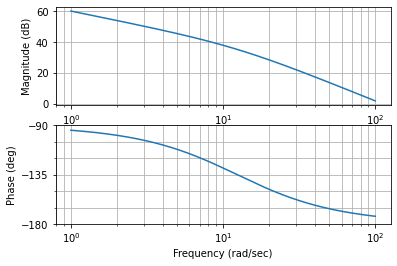

In [17]:
kc_lag = 7634
gain_comp_lag = control.tf([kc_lag], [1])
gain_comp_lag_sys = control.series(gain_comp_lag, sys)
control.bode(gain_comp_lag_sys, dB=True)
gm, pm, wcg, wcp = control.margin(gain_comp_lag_sys)
print('Margem de ganho: ', gm)
print('Margem de fase: ', pm)

Sabendo a margem de fase, podemos determinar o coeficiente de amortecimento $\zeta$ usando a expressão abaixo

\begin{align}
\zeta = -\frac{ln(M_p)}{\sqrt{\pi^2 + ln(M_p)^2}}
\end{align}

In [18]:
Mp_lag = 0.05
dampening_coef = -np.log(Mp_lag)/np.sqrt(np.pi**2 + np.log(Mp_lag)**2)
print('Coef. de amortecimento: ', dampening_coef)

Coef. de amortecimento:  0.6901067305598217


A partir do coeficiente de amortecimento podemos determinar a margem de fase usando a expressão

\begin{align}
MF = tan^{-1} \left(\frac{2 \zeta}{\sqrt{\sqrt{1+4\zeta^4} - 2\zeta^2}} \right)
\end{align}

In [19]:
MF_lag = np.arctan((2*dampening_coef)/(np.sqrt(np.sqrt(1 + 4*dampening_coef**4) - 2*dampening_coef**2)))
print('Margem de fase desejada: ', np.degrees(MF_lag))

Margem de fase desejada:  64.62530291861535


Usando a margem de fase encontrada anteriormente temos que o atraso de fase deve ser $\phi_m = MF - 180˚ = 64,63˚ - 180˚ = -115,37˚$

No diagrame de bode, a fase é -115,37˚ quando $\omega = 6 rad/s$. E, nessa frequência, $|P(j\omega_c)| = -32dB$

Com isso, calcula-se a atenuação necessária $\alpha$ utilizando a expressão

\begin{align}
20log(\alpha) = atenuação
\end{align}

In [20]:
alpha_lag = 10**(-32/20)
print('alpha: ', alpha_lag)

alpha:  0.025118864315095794


Finalmente, podemos encontrar o controlador por atraso de forma

\begin{align}
G_{lag} =  \frac{90 + 60}{1 + 0.6}
\end{align}

O diagrama de Bode do compensador está plotado abaixo.


90 s + 60
---------
 s + 0.6



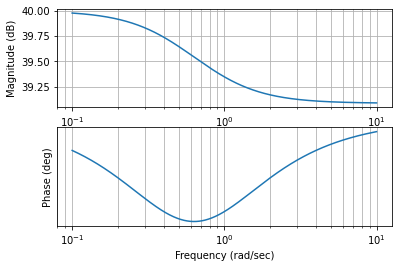

In [21]:
lag_compensator = control.tf(np.array([90, 60]), np.array([1, 0.6]))
control.bode(lag_compensator, dB=True)
print(lag_compensator)

Aplicando o controlador por atraso ao sistema, obtemos a função de transferência e o diagrama de Bode demonstrados abaixo.


       156.6 s + 104.4
------------------------------
1.075 s^3 + 13.91 s^2 + 7.96 s



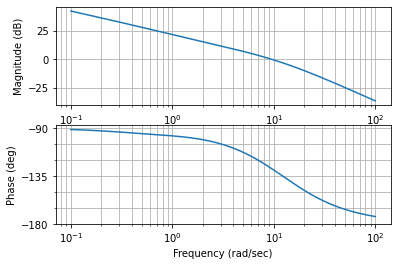

In [22]:
sys_lag_compensated = control.series(lag_compensator, sys)
control.bode(sys_lag_compensated, dB=True)
print(sys_lag_compensated)

Finalmente, uma vez que conhecemos a função de transferência do sistema compensado, podemos plotar a sua resposta ao degrau unitário e à rampa.

{'RiseTime': 0.14599578175416694, 'SettlingTime': 0.6256962075178584, 'SettlingMin': 0.9455029696433259, 'SettlingMax': 1.1602500024340157, 'Overshoot': 16.025000243401564, 'Undershoot': 0, 'Peak': 1.1602500024340157, 'PeakTime': 0.3128481037589292, 'SteadyStateValue': 1.0}


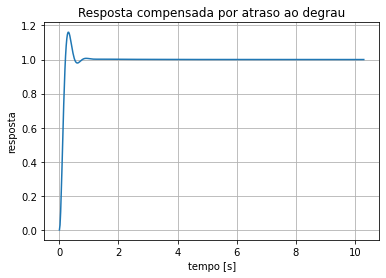

In [23]:
# Resposta ao degrau unitário
closed_lag_compensated_sys = control.feedback(sys_lag_compensated, 1)
time, response = control.step_response(closed_lag_compensated_sys)
plt.plot(time, response)
plt.xlabel("tempo [s]")
plt.ylabel("resposta")
plt.title("Resposta compensada por atraso ao degrau")
plt.grid()
print(control.step_info(closed_lag_compensated_sys))

Text(0.5, 1.0, 'Resposta compensada por atraso à rampa')

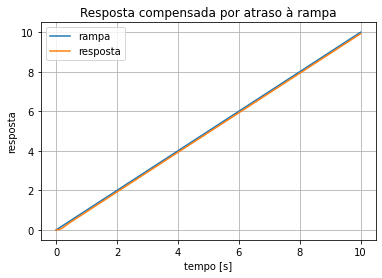

In [24]:
# Resposta à rampa unitária
t = np.linspace(0, 10, 100)
ramp = np.linspace(0, 10, 100)
time, response = control.forced_response(closed_lag_compensated_sys, U=ramp, T=t)
plt.plot(t, ramp)
plt.plot(t, response)
plt.legend(['rampa', 'resposta'])
plt.xlabel("tempo [s]")
plt.ylabel("resposta")
plt.grid(True)
plt.title('Resposta compensada por atraso à rampa')

A partir desses gráficos de resposta do sistema compensado, podemos chegar a algumas conclusões. Primeiro, percebemos que o transitório do sistema se torna mais instável e o requisito de desempenho de máximo sobressinal em 5% não é atendido. No entando, percebemos que uma consequência dessa aceleração da resposta do sistema é que ele faz com que o regime transitório dure menos e, quando ele acaba, o sistema está dentro das especificações para o erro máximo de estado estacionário menor que 0.1%.

Para fazer com que o sistema atinja os critérios de desempenho, temos que ajustar o ganho do compensador. Reduzindo o ganho do compensador de modo a obter

## Projeto do Compensador de Avanço e Atraso de Fase
**Projetar controlador por atraso e avanço de fase de modo que $e_{ss} < 0.1\%$, $M_p < 5\% $ e $t_p < 0.1s$**


Assim como fizemos anteriormente, começamos o projeto pelo erro de estado estacionário desejado. Nesse caso temos:

\begin{align}
e_{ss} = \frac{1}{K} \lt 0.1\% \implies K = \frac{1}{e_{ss}} \gt 1000 \implies K_c \gt \frac{1000}{0.131}
\end{align}

Encontrasmos então um ganho do compensador de 7634 assim como no item anterior. Assim, o diagrama de Bode com ganho compensado toma a forma mostrada abaixo.


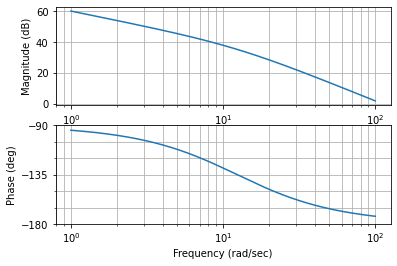

In [25]:
kc_lag_lead = 1000/0.131
gain_comp_lag_lead = control.tf([kc_lag_lead], [1])
gain_comp_lag_lead_sys = control.series(gain_comp_lag_lead, sys)
control.bode(gain_comp_lag_lead_sys, dB=True)
print()

Podemos então usar as outras especificações do projeto para encontrar os parâmetros do compensador. Com a especificação de máximo sobressinal temos:

\begin{equation}
\xi = \frac{-ln(M_p)}{\sqrt{\pi^2 + (ln(M_p))^2}} \Rightarrow \xi = \frac{-ln(0,05)}{\sqrt{\pi^2 + (ln(0,05))^2}} ⇔ \xi = 0,69
\end{equation}


In [26]:
Mp_lag_lead = 0.05
dampening_coef_lag_lead = -np.log(Mp_lag_lead)/np.sqrt(np.pi**2 + np.log(Mp_lag_lead)**2)
print('Coef. de amortecimento: ', dampening_coef_lag_lead)

Coef. de amortecimento:  0.6901067305598217


Uma vez que temos o coeficiente de amortecimento do sistema e o tempo de pico desejado pelos cirtérios de desempenho, podemos determinar sua frequência natural pela expressão abaixo.


\begin{equation}
\omega_n = \frac{\pi}{t_p \sqrt{1-\xi^2}} \Rightarrow \omega_n = \frac{\pi}{0,1\sqrt{1-0,69^2}}
\end{equation}



In [27]:
tp_lag_lead = 0.1
wn = np.pi/(tp_lag_lead*np.sqrt(1-dampening_coef_lag_lead**2))
print('wn: ', wn)

wn:  43.40969506446956


O proximo passo e definir a largura de banda do sistema.

\begin{equation}
BW = \omega_n \sqrt{(1-2\xi^2) + \sqrt{4\xi^4 - 4\xi^2 +2}}
\end{equation}



In [28]:
BW = wn*np.sqrt((1-2*dampening_coef_lag_lead**2) + np.sqrt(4*dampening_coef_lag_lead**4 - 4*dampening_coef_lag_lead**2 +2 ))
print('largura de banda: ', BW)

largura de banda:  44.4527390152243


A nova frequencia de cruzamento de ganho sera proxima a BW, para fins praticos, foi usado 80% dela: $\omega_{cg} = 1.05 \cdot BW$. A partir dessa frequência é possível determinar o parâmetro $T_2$.

In [29]:
wcg = 1.04*BW
print(f'wcg: {wcg}')

wcg: 46.23084857583328


Pelo diagrama de Bode, podemos perceber que a margem de fase quando $\omega = \omega_{cg}$ é de aproximadamente 15˚. Precisamos agora calcular qual seria a margem de fase dado o valor de $\xi$.

In [30]:
MF_xi_rad = np.arctan(2*dampening_coef_lag_lead/np.sqrt(np.sqrt(1 + 4*dampening_coef_lag_lead**4) - 2*dampening_coef_lag_lead**2))
MF_xi = np.degrees(MF_xi_rad)
print(f'MF pelo coef. de amortecimento: {MF_xi}')

MF pelo coef. de amortecimento: 64.62530291861535


O angulo $\phi_m$ será a diferença desses dois valores: $\phi_m = 64,6° - 15° = 46,6°$. Ao fazer os ajustes, foi adicionado um incremento de 28,4°, chegando em $\phi_m = 75°$. Com isso, é possível achar o coeficiente de amortecimento $\alpha$, pela forma:

\begin{equation}
  \alpha = \frac{1-sen(\phi_m)}{1+sen(\phi_m)} \Rightarrow \alpha = \frac{1-sen(75°)}{1+sen(75°)} \Leftrightarrow \alpha = 0,017
\end{equation}

Analisando a resposta do sistema, no entanto, percebemos que esse fator de atenuação era grande demais e fazia com que o sistema tivesse uma resposta muito lenta, portanto aumentamos a MF desejada para 90˚ de modo a obter $\phi_m \approx 75$ conforme calculado na célula abaixo.

In [31]:
def find_atenuation(phi):
  return (1 - np.sin(np.radians(phi))) / (1 + np.sin(np.radians(phi)))

alpha2 = find_atenuation(75)
print(f'Coeficiente de atenuacao: {alpha2}')

Coeficiente de atenuacao: 0.017332380120999257


Com isso têm-se todos os parâmetros necessários para gerar a função de transferência do compensador, a qual é da forma:

\begin{equation}
  G_c(s) = \left(\frac{s + \frac{1}{T_1}}{s + \frac{1}{\alpha T_1}}\right)
          \left(\frac{s + \frac{1}{T_2}}{s + \frac{\alpha}{T_2}}\right)
\end{equation}

Onde, $\frac{1}{T_1} = \omega_{cg}\sqrt{\alpha}$  e  $\frac{1}{T_2} = \frac{\omega_{cg}}{10}$

Foi adicionado, também, um incremento de 10% no ganho, o qual acelerou o sistema e colaborou para que os requisitos fossemc cumpridos.

In [32]:
inverse_T1 = wcg*np.sqrt(alpha2)
inverse_T2 = wcg/10

lead_part = control.tf(1.1*(1/alpha2)*np.array([1, inverse_T1]), [1, inverse_T1/alpha2]) # incremento de 10% no ganho
lag_part = control.tf(alpha2*np.array([1, inverse_T2]), [1, alpha2*inverse_T2])

lead_lag_compensator = control.series(lead_part, lag_part)

print(f'Compensador por avanço: {lead_part}')
print(f'Compensador por atrasdo: {lag_part}')
print(f'Compensador por avanço-atraso: {lead_lag_compensator}')

Compensador por avanço: 
63.47 s + 386.3
---------------
   s + 351.2

Compensador por atrasdo: 
0.01733 s + 0.08013
-------------------
    s + 0.08013

Compensador por avanço-atraso: 
1.1 s^2 + 11.78 s + 30.95
-------------------------
  s^2 + 351.2 s + 28.14



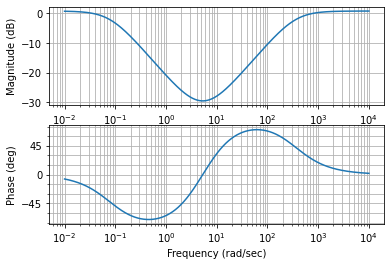

In [33]:
mag, phase, omega = control.bode(lead_lag_compensator, dB=True)


  1.461e+04 s^2 + 1.564e+05 s + 4.11e+05
------------------------------------------
1.075 s^4 + 390.9 s^3 + 4690 s^2 + 373.3 s



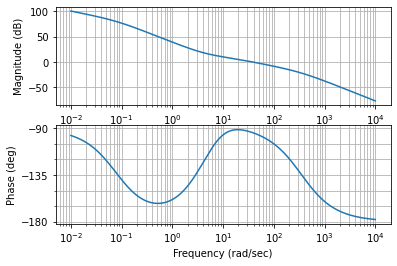

In [34]:
sys_with_lead_lag_comp = control.series(gain_comp_lag_lead_sys, lead_lag_compensator)
control.bode(sys_with_lead_lag_comp,dB=True)
print(sys_with_lead_lag_comp)

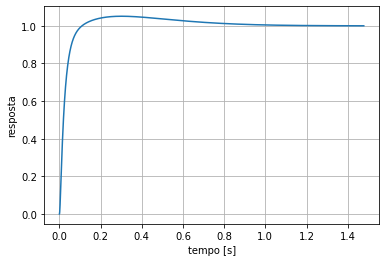

In [35]:
closed_lead_lag_compensated_sys = control.feedback(sys_with_lead_lag_comp, 1)
time, response = control.step_response(closed_lead_lag_compensated_sys)
plt.plot(time, response)
plt.xlabel("tempo [s]")
plt.ylabel("resposta")
plt.grid()

In [36]:
print(control.step_info(closed_lead_lag_compensated_sys))

{'RiseTime': 0.05317018315074424, 'SettlingTime': 0.6799475116480767, 'SettlingMin': 0.9005857726926552, 'SettlingMax': 1.0508932231722392, 'Overshoot': 5.089322317223933, 'Undershoot': 0, 'Peak': 1.0508932231722392, 'PeakTime': 0.3018984975508359, 'SteadyStateValue': 0.9999999999999999}


Text(0.5, 1.0, 'Resposta compensada por avanço e atraso à rampa')

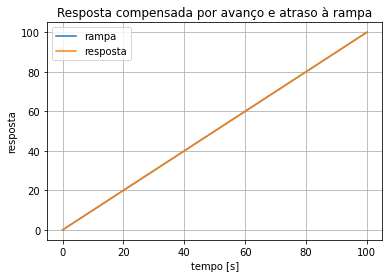

In [37]:
# Resposta à rampa unitária
t = np.linspace(0, 100, 100)
ramp = np.linspace(0, 100, 100)
time, response = control.forced_response(closed_lead_lag_compensated_sys, U=ramp, T=t)
plt.plot(t, ramp)
plt.plot(t, response)
plt.legend(['rampa', 'resposta'])
plt.xlabel("tempo [s]")
plt.ylabel("resposta")
plt.grid(True)
plt.title('Resposta compensada por avanço e atraso à rampa')

Analisando a resposta do sistema compesada por atraso e avanço podemos perceber que o requisito de erro estácionário foi atingido. O de máximo sobressinal, embora não tenha atingido os 5% ficou muito próximo com um valor de $Mp = 5,09\%$ e o mesmo ocorre para o tempo de pico em $t_p = 0,3s$. Concluímos então que esse controlador tem um desempenho adequado para as especificações fornecidas.

## Comentários Finais

A partir do desenvolvimento desse projeto é possível observar as diferenças de efeito de cada tipo de controlador estudado durante a disciplina. Cada um dos métodos de compensar o sistema apresenta vantagens e desvantagens que são discutidas abaixo.

O compensador por avanço de fase permite que o erro de estado estacionário do sistema seja ajustado para um valor muito menor, mas não interfere na sua resposta transitória, o que não é ideal para um sistema de resposta lenta como o estudado nesse projeto. O compensador por atraso, por sua vez, permite tornar a resposta do sistema mais rápida reduzindo seu tempo de pico e acomodação enquanto reduz o erro de estado estacionário. O custo dessa melhoria no regime transitório é uma perda de margem de fase e aumento das oscilações que pode inclusive levar o sistema à instabilidade. Finalmente, o compensador por avanço e atraso traz equilíbrio entre esses dois métodos combinando um compensador de cada tipo em série. Para esse tipo de compensador é possível controlar tanto a repsosta em regime transitório quando a resposta em estado estacionário de forma a obter um comportamento mais próximo de requisitos de projeto estritos como aqueles dados nesse trabalho. A desvantagem desse tipo de controlador, no entanto, é sua complexidade de projeto e implementação.

## Referências

DORF, Richard C; BISHOP, Robert H. **Modern Control Systems**. 13a Edição. Boston: Pearson, 2019.